In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import pandas as pd


In [2]:
api_key = '7a802e204a08789569034837ff203fb7'
url_base = 'https://api.stlouisfed.org/fred/series/observations'

def fetch_and_clean_data(series_ids, start_date='2000-01-01', end_date='2024-12-31'):
    """ pulls macro economic data from the given series ID with specified start and 
        end date and cleans the data
    
    Args:
        series_ids (list): list of macro economic series id to get from the API
        start_date (str) : start date for collecting data in YY-MM-DD format
        end_date (str) : end date for collecting data in YY-MM-DD format
    Returns:
        merged_df (DataFrame): a merged dataframe with numerical and categorical data from
                                the series requested. Each column corresponds to a series ID 
                                with its values
    """
    # Creating an empty list to store all values
    all_data = []
    
    # Using for loop to iterate through each series ID to get data from API key  
    for series_id in series_ids:
        params = {
            'series_id': series_id,
            'api_key': api_key,
            'file_type': 'json',
            'observation_start': start_date,
            'observation_end': end_date
        }
        
        # Sending a request to API
        response = requests.get(url_base, params=params)
        data = response.json()['observations']
        
        # Creating the dataframe
        df = pd.DataFrame(data)
        df = df[['date', 'value']]
        # Converting the values to numeric and date in datetime format
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        df['date'] = pd.to_datetime(df['date'])
        
        # Renaming the value column to series ID
        df.rename(columns={'value': series_id}, inplace=True)
        
        # Append DataFrame to the list
        all_data.append(df)
    
    # Merging all data on the 'date' column
    merged_df = all_data[0]
    for df in all_data[1:]:
        merged_df = pd.merge(merged_df, df, on='date', how='outer')

    # Adding categorical feature: Inflation Level
    if 'CPIAUCSL' in series_ids:
        merged_df['Inflation_Level'] = pd.cut(merged_df['CPIAUCSL'], 
                                              bins=[-float('inf'), 2, 3, float('inf')], 
                                              labels=['Low', 'Medium', 'High'])
    
    # Calculating GDP growth rate and categorizing it as recession, stagnation, or growth
    if 'GDP' in series_ids:
        merged_df['GDP_Growth_Rate'] = merged_df['GDP'].pct_change() * 100
        merged_df['GDP_Growth_Stage'] = pd.cut(merged_df['GDP_Growth_Rate'], 
                                               bins=[-float('inf'), 0, 2, float('inf')], 
                                               labels=['Recession', 'Stagnation', 'Growth'])
 # Saving the merged DataFrame to a CSV file
    merged_df.to_csv('macro_data.csv', index=False)

    return merged_df

In [3]:
# list of series ID
series_ids = ['GDP', 'UNRATE', 'CPIAUCSL', 'RSAFS', 'INDPRO']
merged_df = fetch_and_clean_data(series_ids)

/var/folders/zk/nk76x8qj7w7_qbtd9m_52nfw0000gn/T/ipykernel_8250/1838909399.py:60: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  merged_df['GDP_Growth_Rate'] = merged_df['GDP'].pct_change() * 100


In [4]:
# Printing merged_df
merged_df

,date,GDP,UNRATE,CPIAUCSL,RSAFS,INDPRO,Inflation_Level,GDP_Growth_Rate,GDP_Growth_Stage
0,2000-01-01,10002.179,4.0,169.300,268044.0,91.4092,High,NaN,NaN
1,2000-04-01,10247.720,3.8,170.900,271046.0,92.6659,High,2.454875,Growth
2,2000-07-01,10318.165,4.0,172.700,272630.0,92.8373,High,0.687421,Stagnation
3,2000-10-01,10435.744,3.9,173.900,276927.0,92.6400,High,1.139534,Stagnation
4,2001-01-01,10470.231,4.2,175.600,278834.0,91.8908,High,0.330470,Stagnation
...,...,...,...,...,...,...,...,...,...
293,2024-05-01,NaN,4.0,313.225,704309.0,102.9797,High,0.000000,Recession
294,2024-06-01,NaN,4.1,313.049,702350.0,103.2768,High,0.000000,Recession
295,2024-08-01,NaN,4.2,314.121,710038.0,103.0449,High,0.000000,Recession
296,2024-09-01,NaN,4.1,314.686,716026.0,102.5497,High,0.000000,Recession


In [5]:
# API key and symbol
api_key = 'R4X2TGAG91Y4NM9G'
symbol = 'NFLX'

# Fetch stock market data using Alpha Vantage API
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={api_key}&outputsize=full'
response = requests.get(url)

# Extract the JSON data
data = response.json()

# Check if the response contains time series data
if "Time Series (Daily)" in data:
    # Convert the time series data into a DataFrame
    time_series = data["Time Series (Daily)"]
    
    # Create a DataFrame from the time series data
    stock_data = pd.DataFrame.from_dict(time_series, orient='index')
    
    # Rename the columns for easier access
    stock_data.columns = ['open', 'high', 'low', 'close', 'volume']
    
    # Convert the index to datetime
    stock_data.index = pd.to_datetime(stock_data.index)
    
    # Convert numeric columns to float
    stock_data = stock_data.astype(float)
    
    # Display the first few rows of the stock data
    print("Stock Data:")
    print(stock_data)
else:
    print("No time series data found.")

Stock Data:
              open    high       low   close     volume
2024-11-29  882.17  892.41  876.6800  886.81  2027237.0
2024-11-27  872.06  880.95  858.9100  877.34  2578222.0
2024-11-26  867.49  886.36  867.2501  872.60  3138259.0
2024-11-25  902.05  902.05  864.2200  865.59  6014203.0
2024-11-22  896.00  906.00  893.0000  897.79  3214020.0
...            ...     ...       ...     ...        ...
2002-05-30   15.51   15.51   15.0000   15.00   725300.0
2002-05-29   16.30   16.30   15.2000   15.45   482700.0
2002-05-28   16.99   17.25   16.2000   16.20   472100.0
2002-05-24   17.00   17.15   16.7600   16.94   793200.0
2002-05-23   16.19   17.40   16.0400   16.75  7485000.0

[5670 rows x 5 columns]


In [6]:
def extract_monthly_stock_prices(stock_data):
    """
    Extract stock prices that match the monthly dates in the macroeconomic dataset
    args:
        stock_data (DataFrame): data frame that consists of stock info (open, high, low, close, volume) from everyday the stock market was
                                open from May 23, 2002 to October 23, 2024
    returns:
        filtered_stock_data (DataFrame): data frame that consists of the same stock info but filtered to only include the first of 
                                         every month that the stock market was open
    """
    
    # Extract dates from the macroeconomic dataset
    monthly_dates = merged_df['date']
    
    # Filter stock data to include only the dates that are in the macroeconomic data
    filtered_stock_data = stock_data[stock_data.index.isin(monthly_dates)]
    
    return filtered_stock_data

filtered_stock_data = extract_monthly_stock_prices(stock_data)

# flip order so it is chronological like the other dataset. some months are missing because there is no data from the first of those month
filtered_stock_data = filtered_stock_data.sort_index(ascending=True)

filtered_stock_data

,open,high,low,close,volume
2002-07-01,14.00,14.6500,13.900,14.39,327500.0
2002-08-01,13.30,13.4400,12.290,12.48,323500.0
2002-10-01,9.93,9.9400,9.250,9.50,275000.0
2002-11-01,8.80,9.0000,8.500,8.94,151900.0
2003-04-01,20.50,20.5800,18.560,18.96,1215700.0
...,...,...,...,...,...
2024-04-01,608.00,615.1100,605.571,614.31,2063845.0
2024-05-01,547.84,560.3900,544.250,551.71,3473233.0
2024-07-01,674.89,675.0200,663.780,673.61,2212826.0
2024-08-01,629.25,646.7099,617.610,624.85,3720573.0


In [7]:
# Combine the macroeconomic data and the filtered stock data
filtered_stock_data['date'] = pd.to_datetime(filtered_stock_data.index)
macro_and_stock_df = pd.merge(merged_df, filtered_stock_data, on='date', how='outer')

# Display the combined data starting July 1, 2002 (when extracted stock data starts)
macro_and_stock_df.iloc[30:]

,date,GDP,UNRATE,CPIAUCSL,RSAFS,INDPRO,Inflation_Level,GDP_Growth_Rate,GDP_Growth_Stage,open,high,low,close,volume
30,2007-07-01,14564.117,4.7,207.603,369614.0,101.4953,High,1.125080,Stagnation,NaN,NaN,NaN,NaN,NaN
31,2007-10-01,14715.058,4.7,209.190,375289.0,101.6446,High,1.036390,Stagnation,20.70,21.4000,20.59,21.22,1361200.0
32,2008-01-01,14706.538,5.0,212.174,375236.0,102.1493,High,-0.057900,Recession,NaN,NaN,NaN,NaN,NaN
33,2008-04-01,14865.701,5.0,213.942,372572.0,100.7554,High,1.082260,Stagnation,35.50,36.9000,34.40,36.51,2310500.0
34,2008-07-01,14898.999,5.8,219.016,375038.0,99.4194,High,0.223992,Stagnation,26.80,27.5700,26.44,27.10,2517100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,2024-05-01,NaN,4.0,313.225,704309.0,102.9797,High,0.000000,Recession,547.84,560.3900,544.25,551.71,3473233.0
294,2024-06-01,NaN,4.1,313.049,702350.0,103.2768,High,0.000000,Recession,NaN,NaN,NaN,NaN,NaN
295,2024-08-01,NaN,4.2,314.121,710038.0,103.0449,High,0.000000,Recession,629.25,646.7099,617.61,624.85,3720573.0
296,2024-09-01,NaN,4.1,314.686,716026.0,102.5497,High,0.000000,Recession,NaN,NaN,NaN,NaN,NaN


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

/Users/darsheenchona/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/darsheenchona/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/darsheenchona/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/darsheenchona/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

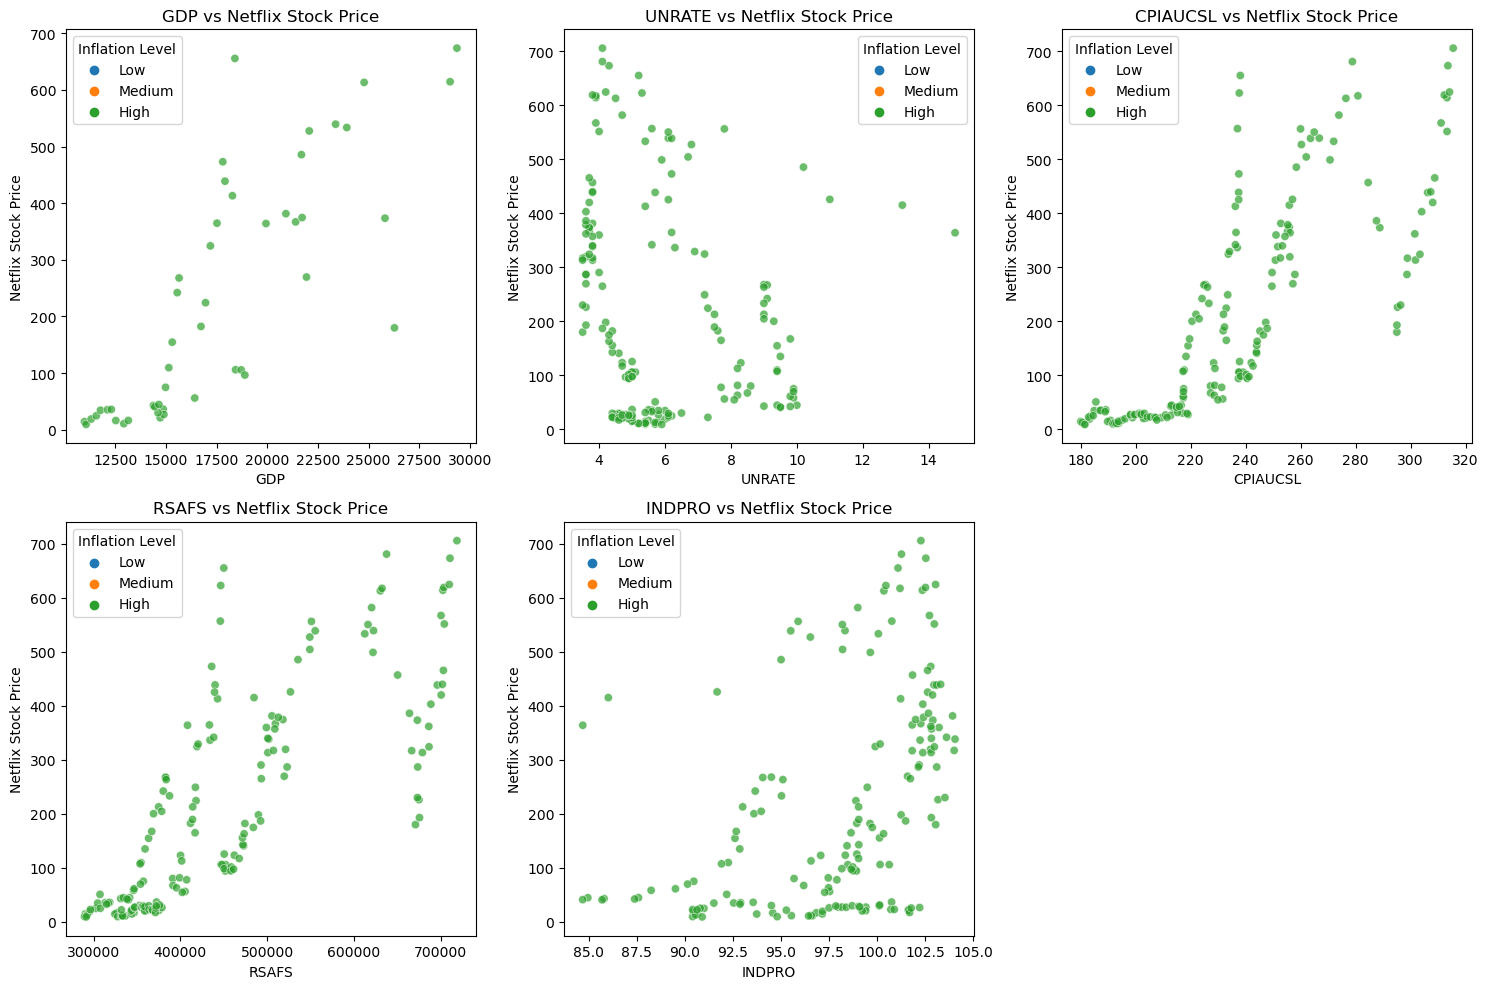

In [9]:
# Visualization 1: Scatter plots for each numerical macroeconomic factor
macroeconomic_factors = ['GDP', 'UNRATE', 'CPIAUCSL', 'RSAFS', 'INDPRO']

# Scatter plots for each macroeconomic factor compared to Netflix stock closing price 
plt.figure(figsize=(15, 10))

for i, factor in enumerate(macroeconomic_factors, start=1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=macro_and_stock_df, x=factor, y='close', hue='Inflation_Level', alpha=0.7)
    plt.title(f'{factor} vs Netflix Stock Price')
    plt.xlabel(factor)
    plt.ylabel('Netflix Stock Price')
    plt.legend(title='Inflation Level')

plt.tight_layout()
plt.show()

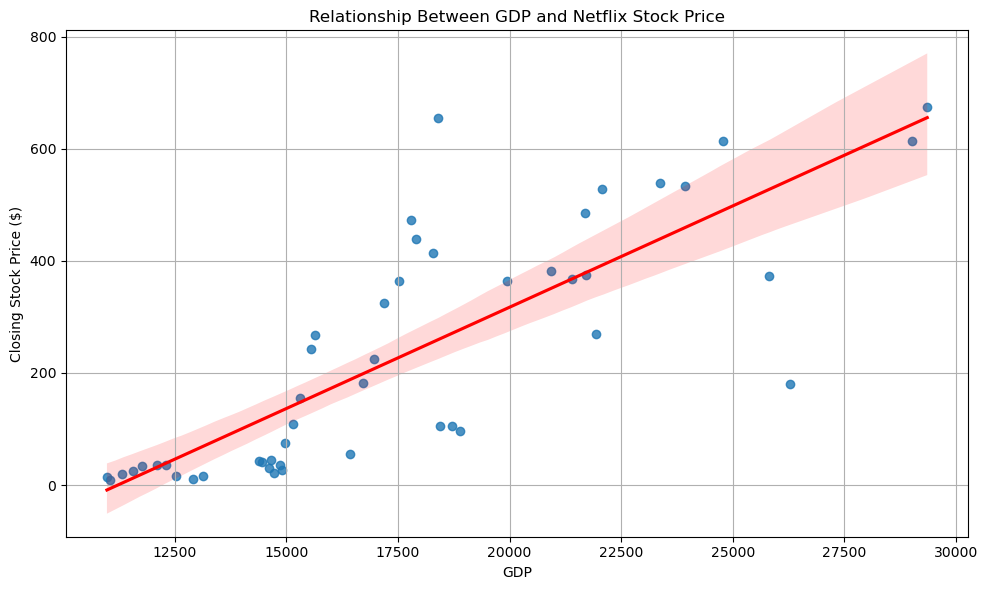

In [10]:
# Visualization 2: Scatter plot w/ line of best fit of GDP vs Netflix stock price

plt.figure(figsize=(10, 6))
sns.regplot(x='GDP', y='close', data=macro_and_stock_df, line_kws={'color':'red'})

plt.title('Relationship Between GDP and Netflix Stock Price')
plt.xlabel('GDP')
plt.ylabel('Closing Stock Price ($)')
plt.grid()
plt.tight_layout()
plt.show()

In [11]:
# Visualization 3: CPI vs Netflix stock price over time layered line graph

macro_and_stock_df['date'] = pd.to_datetime(macro_and_stock_df['date'])
macro_and_stock_df.set_index('date', inplace=True)

macro_and_stock_df['close'] = macro_and_stock_df['close'].interpolate(method='time')

plt.figure(figsize=(12, 6))
plt.plot(macro_and_stock_df['close']['2002':'2024'], label='Netflix Stock Price', color='blue')

# Set x-axis limits to focus on the years 2002-2024
plt.xlim(pd.Timestamp('2002-01-01'), pd.Timestamp('2024-12-31'))

# Setting x-ticks to show only the years
plt.xticks(ticks=pd.date_range(start='2002-01-01', end='2024-12-31', freq='YE'), labels=range(2002, 2025))

plt.plot(macro_and_stock_df['CPIAUCSL']['2002':'2024'], label='CPI', color='orange')

plt.title('Netflix Stock Price and CPI Over Time (2002-2024)')
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()


KeyError: 'Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is not allowed.'

<Figure size 1200x600 with 0 Axes>

/var/folders/zk/nk76x8qj7w7_qbtd9m_52nfw0000gn/T/ipykernel_8250/1741317123.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  economic_cycle_data = macro_and_stock_df.groupby('GDP_Growth_Stage')['close'].mean()


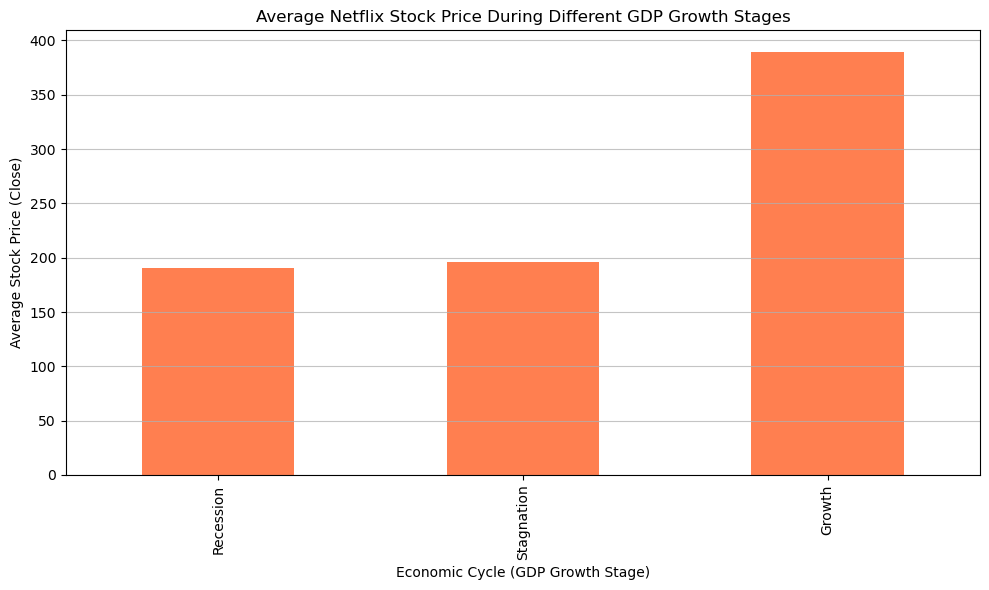

In [12]:
# Visualization 4: bar graph of average Netflix stock prices during different growth stages

economic_cycle_data = macro_and_stock_df.groupby('GDP_Growth_Stage')['close'].mean()

plt.figure(figsize=(10, 6))
economic_cycle_data.plot(kind='bar', color='coral')

plt.title('Average Netflix Stock Price During Different GDP Growth Stages')
plt.xlabel('Economic Cycle (GDP Growth Stage)')
plt.ylabel('Average Stock Price (Close)')

plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

In [13]:
#Implementation of ML model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
sns.set()

In [14]:
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d

    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
    else:
        raise ValueError("Input array must be either 1-d or 2-d")
    return Xnew


In [15]:
def line_of_best_fit(X, y):
    """
    Calculates the coefficients for the line of best fit including the intercept

    Args:
        X (array): Predictor values - can be either 1-d or 2-d (excluding the bias term).
        y (array): Response values - must be 1-d.

    Returns:
        coefficients (array): Coefficients for the line of best fit including the intercept
    """
    
    # add bias column
    X_bias = add_bias_column(X)
    X_transpose = np.transpose(X_bias)
    
    # calculating line of best fit 
    coefficients = np.linalg.inv(np.dot(X_transpose, X_bias)).dot(np.dot(X_transpose, y))
    return coefficients

In [16]:
def linreg_predict(Xnew, ynew, m):
    """
    Predicts response values, calculates residuals, MSE, and R^2 for linear regression

    Args:
        Xnew (array): Predictor values, can be either 1-d or 2-d (excluding the bias term)
        ynew (array): Response values, must be 1-d.
        m (array): Coefficients from line_of_best_fit, length should be p+1

    Returns:
        result (dict): A dictionary containing:
            - 'ypreds': Predicted values for Xnew using the regression model
            - 'resids': Residuals
            - 'mse': Mean squared error
            - 'r2': R squared value
    """
    X_new_with_bias = add_bias_column(Xnew)
    ypreds = np.dot(X_new_with_bias, m)

    # Residuals
    resids = ynew - ypreds

    # CalculateS MSE and R^2 and stores them in a dictionary
    mse = np.mean(resids ** 2)
    r2 = r2_score(ynew, ypreds)
    return {
        'ypreds': ypreds,
        'resids': resids,
        'mse': mse,
        'r2': r2
    }

In [17]:
# cleaning the data
macro_and_stock_df = pd.read_csv('macro_and_stock_df.csv')
macro_and_stock_df

# Removing rows with NaN values
cleaned_df = macro_and_stock_df.dropna()
cleaned_df.head()

,GDP,UNRATE,CPIAUCSL,RSAFS,INDPRO,Inflation_Level,GDP_Growth_Rate,GDP_Growth_Stage,open,high,low,close,volume
30,10984.040,5.8,180.0,290385.0,90.6436,High,0.887076,Stagnation,14.00,14.65,13.90,14.39,327500.0
33,11061.433,5.7,181.2,289576.0,90.3988,High,0.704595,Stagnation,9.93,9.94,9.25,9.50,275000.0
39,11312.766,6.0,183.2,295600.0,90.4311,High,1.240696,Stagnation,20.50,20.58,18.56,18.96,1215700.0
42,11566.669,6.2,183.7,302747.0,90.9869,High,2.244394,Growth,25.60,25.60,24.26,24.75,882600.0
45,11772.234,6.0,184.9,304809.0,91.5049,High,1.777219,Stagnation,33.60,35.49,33.40,34.51,991200.0


In [18]:
# Splitting the data into Predictors and Target
X = cleaned_df['GDP'].values  
y = cleaned_df['close'].values  

# Scaling the Data
X_mean, X_std = X.mean(), X.std()
y_mean, y_std = y.mean(), y.std()
X_scaled = (X - X_mean) / X_std
y_scaled = (y - y_mean) / y_std

# Splitting the Data into Training and Testing Sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=3)

# Reshaping X and Y to Ensure They Are 2D
Xtrain = Xtrain.reshape(-1, 1)
Xtest = Xtest.reshape(-1, 1)

# Applying line_of_best_fit on the training data
m = line_of_best_fit(Xtrain, ytrain)

# Use linreg_predict on the test data
result = linreg_predict(Xtest, ytest, m)
print("Cross-validated MSE (scaled):", result['mse'])
print("Cross-validated R^2 (scaled):", result['r2'])

Cross-validated MSE (scaled): 0.46484628393184324
Cross-validated R^2 (scaled): 0.5016695040391471


In [19]:
def get_mse(y_true, y_pred):
    
    # calculate the mean squared distance between the predicted and actual y
    return np.mean((y_true - y_pred) ** 2)

In [20]:
def show_fit(X, y, slope, intercept):
    plt.figure()
    
    #in case this wasn't done before, transform the input data into numpy arrays and flatten them
    x = np.array(X).ravel()
    y = np.array(y).ravel()
    
    # plot the actual data
    plt.scatter(x, y, label='data')
    
    #Compute the predicted values for the given data using the slope and intercept
    y_pred = slope * x + intercept
    
    #Plot the linear fit (predicted line) on top of the actual data points
    plt.plot(x, y_pred, color='black', ls=':', label='linear fit')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    
    # Calculate the mean squared error between actual and predicted values
    mse = get_mse(y_true=y, y_pred=y_pred)
    plt.suptitle(f'y_hat = {slope:.3f} * x + {intercept:.3f}, MSE = {mse:.3f}')
    plt.show()


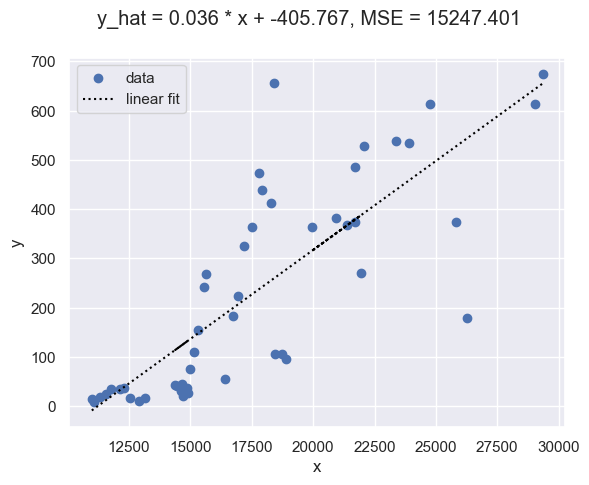

Slope (Beta 1): 0.036
Intercept (Beta 0): -405.767


In [21]:
#Fitting the Model to Full Dataset
m_full = line_of_best_fit(X.reshape(-1, 1), y)

# Extracting Slope and Intercept
intercept = m_full[0]
slope = m_full[1]

# Plotting the Best-Fit Line
show_fit(X, y, slope, intercept)

# Displaying Slope and Intercept
print(f"Slope (Beta 1): {slope:.3f}")
print(f"Intercept (Beta 0): {intercept:.3f}")

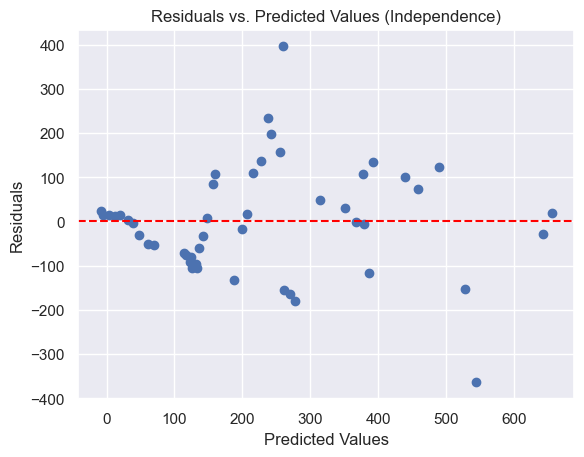

In [22]:
result_full = linreg_predict(X.reshape(-1, 1), y, m_full)
residuals = result_full['resids']

# Independence Check
plt.figure()
plt.scatter(result_full['ypreds'], residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values (Independence)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


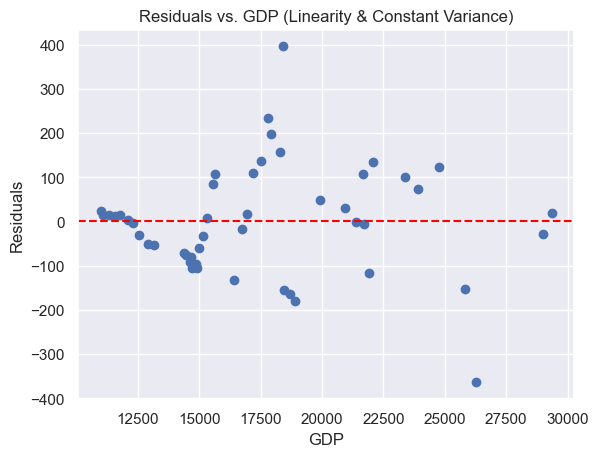

In [23]:
# Constant Variance/Linearity Check
plt.figure()
plt.scatter(X, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. GDP (Linearity & Constant Variance)')
plt.xlabel('GDP')
plt.ylabel('Residuals')
plt.show()

/Users/darsheenchona/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/darsheenchona/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


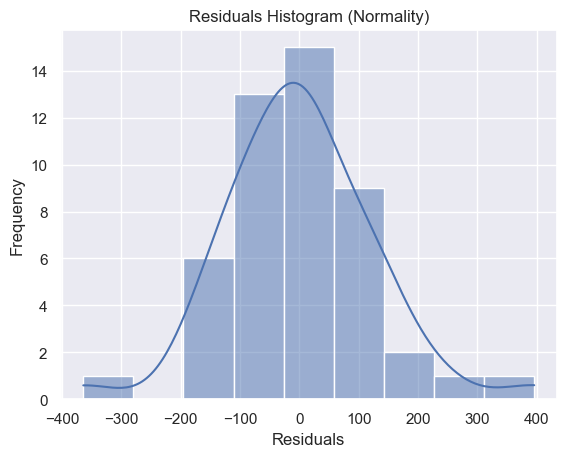

In [24]:
# Normality Check
plt.figure()
sns.histplot(residuals, kde=True)
plt.title('Residuals Histogram (Normality)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Discussion of Preliminary Results
The provided linear regression model uses GDP as the independent variable to predict Netflix's stock price. The equation suggest a positive relationship between GDP and Netflix's stock price. For every unit increase in GDP, the stock price of Netflix increases by 0.036 units. In evaluating the assumptions of the linear regression model relating GDP to Netflix's stock price, we must consider independence, constant variance, linearity, and normality. Independence assumes that each observation of GDP and stock price is independent of the others, which is reasonable since the data points are sampled at specific, non-overlapping time points. However, current stock prices are often influenced by prior prices due to market trends or investor behavior. This means that independence may not be completely met, but we can assume that it is reasonably met. Linearity assumes that the relationship between GDP and stock price can be adequately modeled by a straight line, as represented by the fitted regression line. While the plot shows a general upward trend, deviations from the line at higher GDP values suggest that a purely linear relationship may not fully capture the dynamics, warranting further investigation. Constant variance assumes that the residuals have equal variance across all levels of GDP. However, the scatter plot shows increased spread in stock prices as GDP rises. The R-squared value was calculated to evaluate the goodness of fit for the linear regression model. This value represents the proportion of the variance in the dependent variable (y) that is explained by the independent variable (X). The R-squared value for our model is 0.501. This indicates that approximately 50% of the variability in closing prices can be explained by GDP. A higher R-squared value would signify a stronger relationship between the variables. However, in this preliminary analysis, the R-squared value is lower due to potential non-linear relationships or other contributing factors not accounted for in this simple model. The MSE value came out to be very high 15247. We understand that this shows that there is a lot of variability in the actual data from the predictions. This is partly because GDP is not enough to influence/predict stock close prices. We would need other variables to understand the relationship. Also, we need to scale our values and standardize them. Extreme outlier values in the dataset can skew the regression results, increasing MSE and lowering R-squared values.If stock prices have a large range, it can lead to higher residual errors (MSE). In the final project, we will add other regression models to compare which model is better and can help us understand the relationship between macro economic factors and stock prices better. We would also look at other factors other than GDP in a multiple regression model that would enable us to make better predictions.

In [36]:
def fetch_netflix_net_income(api_key, symbol='NFLX'):
    """
    Fetch Netflix's annual net income data using Alpha Vantage API.

    Args:
        api_key (str): Your Alpha Vantage API key.
        symbol (str): The stock symbol for Netflix (default is 'NFLX').

    Returns:
        DataFrame: A DataFrame containing years and net income (2000–2023).
    """
    # Alpha Vantage Income Statement url
    url = f'https://www.alphavantage.co/query'

    # API parameters
    params = {
        'function': 'INCOME_STATEMENT',
        'symbol': symbol,
        'apikey': api_key
    }

    # Sending a GET request
    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch data, status code: {response.status_code}")
    
    # fetching the JSON response
    data = response.json()
    
    # Checking if the response contains annualReports
    if 'annualReports' not in data:
        raise ValueError("No annualReports data found in the response.")
    
    # Extracting relevant data from annualReports
    annual_reports = data['annualReports']
    years = []
    net_income = []
    
    for report in annual_reports:
        year = report['fiscalDateEnding'][:4]  # Extract year from fiscalDateEnding
        income = report['netIncome']  # Net income in USD
        years.append(int(year))
        net_income.append(float(income))

    # Creating a DataFrame
    df = pd.DataFrame({'Year': years, 'Net Income (Millions)': net_income})

    # Converting Net Income to millions for readability
    df['Net Income (Millions)'] = df['Net Income (Millions)'] / 1_000_000

    # Filtering for years 2009–2023
    df = df[(df['Year'] >= 2009) & (df['Year'] <= 2023)]

    # Sortting by year in ascending order
    df = df.sort_values('Year').reset_index(drop=True)

    return df


In [37]:
api_key = '1IJUZYUNT2ZLKRBF'

# Fetching Netflix's net income data
netflix_income_df = fetch_netflix_net_income(api_key)

# Printting the DataFrame
print(netflix_income_df)

# Saving to a CSV file
netflix_income_df.to_csv('netflix_net_income_2000_2023.csv', index=False)


    Year  Net Income (Millions)
0   2009                115.860
1   2010                160.853
2   2011                226.126
3   2012                 17.152
4   2013                112.403
5   2014                266.799
6   2015                122.641
7   2016                186.678
8   2017                558.929
9   2018               1211.242
10  2019               1866.916
11  2020               2761.395
12  2021               5116.228
13  2022               4491.924
14  2023               5407.990
